please go to this website to download the DataSet: https://www.kaggle.com/ntnu-testimon/paysim1

# Column Description

step - maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).

type - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.

amount - amount of the transaction in local currency.

nameOrig - customer who started the transaction

oldbalanceOrg - initial balance before the transaction

newbalanceOrig - new balance after the transaction

nameDest - customer who is the recipient of the transaction

oldbalanceDest - initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants).

newbalanceDest - new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants).

isFraud - This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.

isFlaggedFraud - The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction.

In [24]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

from sklearn import metrics
from scipy.stats import ttest_ind, chi2_contingency, chisquare
from sklearn.preprocessing import StandardScaler, LabelEncoder, RobustScaler
from sklearn.linear_model import Lasso, Ridge, LogisticRegressionCV, LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split, GridSearchCV
from sklearn.feature_selection import SelectKBest, f_classif
from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler
from imblearn.under_sampling import NearMiss, ClusterCentroids, CondensedNearestNeighbour
from sklearn.metrics import roc_auc_score, roc_curve, auc, confusion_matrix, classification_report, precision_recall_curve, recall_score
from sklearn.metrics import balanced_accuracy_score, average_precision_score
from sklearn.utils import resample

pd.options.display.max_columns = 400

In [25]:
data = 'C:/Users/Wayne/General Assembly stuff/capstones/Fraud/kaggle fraud dataset.csv'
fraud = pd.read_csv(data)

In [26]:
titles = list(fraud.columns)
titles = [x.lower() for x in titles]
titles
fraud.columns = titles
fraud.sample(10)

,step,type,amount,nameorig,oldbalanceorg,newbalanceorig,namedest,oldbalancedest,newbalancedest,isfraud,isflaggedfraud
2536188,205,PAYMENT,4400.68,C707368422,200430.03,196029.35,M1206240262,0.00,0.00,0,0
4710409,332,CASH_IN,241528.72,C1669647953,7636.00,249164.72,C200558010,154816.10,0.00,0,0
4545276,326,PAYMENT,15622.56,C1114308356,15715.00,92.44,M1134902757,0.00,0.00,0,0
6193126,571,CASH_IN,93441.47,C96020457,658.00,94099.47,C16550067,0.00,0.00,0,0
4322613,308,CASH_OUT,178733.70,C412995860,31673.00,0.00,C23629859,0.00,178733.70,0,0
5527546,381,CASH_OUT,43501.12,C1314635656,21938.00,0.00,C1390628366,0.00,43501.12,0,0
3635230,274,PAYMENT,1261.73,C1639760843,0.00,0.00,M783937679,0.00,0.00,0,0
3673542,276,CASH_OUT,110094.82,C1753647475,0.00,0.00,C1824847768,168245.67,278340.49,0,0
5846370,402,CASH_IN,55952.65,C2076624245,6638.00,62590.65,C870385951,772448.98,716496.33,0,0
2587181,207,CASH_OUT,153414.39,C947949033,0.00,0.00,C1587461166,391586.29,545000.68,0,0


In [27]:
def to_lowercase(dataset):
    for col in dataset.columns:
        try:
            dataset[col] = [x.lower() for x in dataset[col]]
        except:
            dataset[col] = dataset[col]
    return dataset

In [119]:
# easier to process if we were to convert everything to lowercase and remove special characters were its unnecessary
fraud = to_lowercase(fraud)
fraud['type'] = [x.replace('_', '') for x in fraud['type']]
fraud.sample(10)

,step,type,amount,nameorig,oldbalanceorg,newbalanceorig,namedest,oldbalancedest,newbalancedest,isfraud,isflaggedfraud
2732139,212,cashin,32489.64,c1158040669,32769.00,65258.64,c970945914,698763.68,666274.04,0,0
4017633,299,payment,14478.46,c486567139,0.00,0.00,m1911171344,0.00,0.00,0,0
4989791,352,payment,2010.93,c238089516,0.00,0.00,m229296587,0.00,0.00,0,0
1654677,158,cashout,371816.28,c27190747,0.00,0.00,c169170918,759512.79,1131329.07,0,0
5874974,403,payment,27160.31,c665083033,21177.32,0.00,m737437570,0.00,0.00,0,0
3475720,258,cashout,299011.21,c290824371,0.00,0.00,c1611053041,2164652.22,2463663.44,0,0
4015149,299,cashin,26224.42,c900322141,8799110.69,8825335.11,c655148472,7533766.43,7507542.01,0,0
3648983,275,payment,5467.98,c126422001,0.00,0.00,m2113528798,0.00,0.00,0,0
6121172,538,cashin,50887.11,c523057604,7063235.83,7114122.93,c1619098607,95421.67,44534.56,0,0
2120528,183,transfer,15120.29,c1471925530,5632.00,0.00,c1152723790,0.00,15120.29,0,0


In [29]:
# is there any insight to be gained from flagged fraud and actual fraud column?
# is flagged fraud seems to act more like a subset to fraud instead of the other way round.
# isflaggedfraud seems not very useful at first glance
print(fraud['isfraud'].value_counts(), '\n', fraud['isflaggedfraud'].value_counts())

0    6354407
1       8213
Name: isfraud, dtype: int64 
 0    6362604
1         16
Name: isflaggedfraud, dtype: int64


In [30]:
# lets check out the types with respect to isfraud
# All fraud cases happens in type 'cashout' and 'transfer'
# All flaggedfraud comes from 'transfer'
fraud.groupby('type').sum()[['isfraud', 'isflaggedfraud']].reset_index()

,type,isfraud,isflaggedfraud
0,cashin,0,0
1,cashout,4116,0
2,debit,0,0
3,payment,0,0
4,transfer,4097,16


In [31]:
# does fraud correlate to any step (time-relation)
# seems like fraud happens at almost every step, 741 out of 744 steps
# will a time series help?
fraud_step = fraud[fraud['isfraud'] == 1][['isfraud', 'step']].sort_values(by = 'step', ascending = True)
len(fraud_step['step'].value_counts())

741

In [32]:
# lets check out the transaction amount for fraud activity
#  quite substential fraud activity comes from transactions that are 10 million dollars.   
# fraud transactions also happens at 0 dollars.
fraud_trans = fraud[fraud['isfraud'] == 1][['isfraud', 'amount']]
fraud_trans['amount'].value_counts()

10000000.00    287
0.00            16
429257.45        4
1165187.89       4
76646.05         2
25529.76         2
2689633.80       2
296699.39        2
1041647.06       2
447474.67        2
445257.43        2
1437291.89       2
3297243.38       2
2198224.71       2
1892137.66       2
266546.68        2
39342.59         2
141410.98        2
230652.43        2
91637.51         2
283400.42        2
585396.14        2
22824.08         2
972009.75        2
556218.01        2
52541.42         2
2131624.18       2
934590.45        2
3011102.29       2
74804.24         2
              ... 
399045.08        1
123194.95        1
229909.57        1
42062.82         1
994453.20        1
454859.39        1
536624.41        1
234377.29        1
407005.78        1
149668.66        1
416001.33        1
181728.11        1
577418.98        1
94372.61         1
2542664.27       1
4953893.08       1
332729.54        1
89571.46         1
40611.22         1
3171085.59       1
291519.84        1
202978.65   

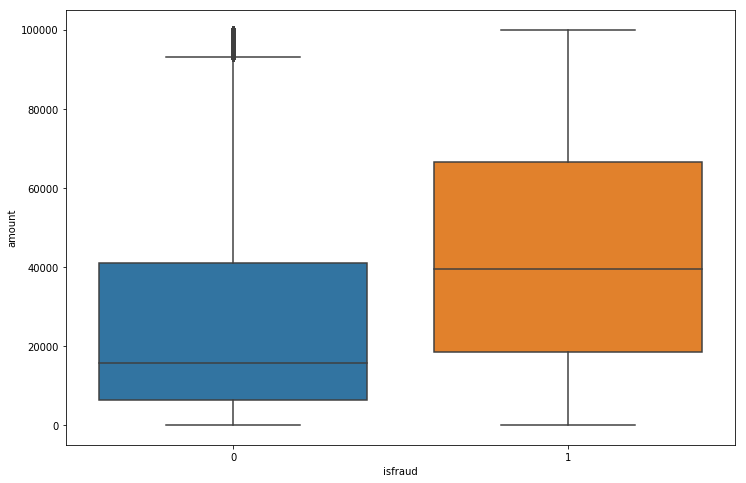

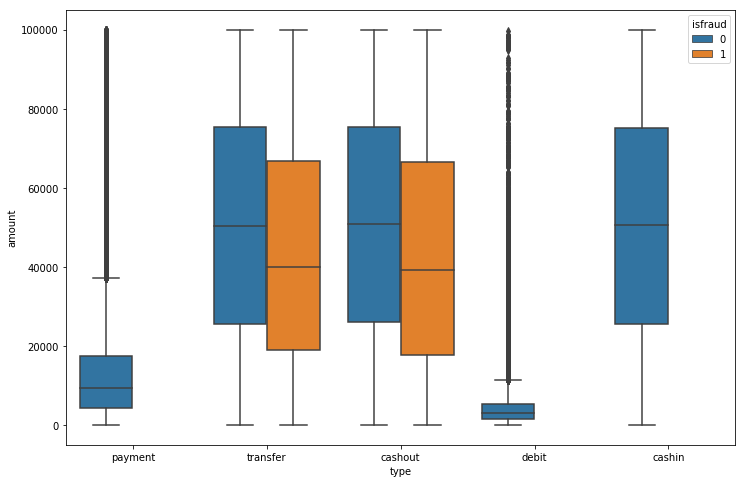

In [33]:
# lets check out the amount within fraud transactions and normal ones, and the transaction type in relation to isfraud and amount
# fraudulent transactions are actually higher than normal ones
# double cfm frud only happens in 2 types, transfer and cashout

plt.figure(figsize=(12,8))
sns.boxplot(x = 'isfraud', y = 'amount', data = fraud[fraud['amount'] < 1e5])
plt.show()
plt.figure(figsize=(12,8))
sns.boxplot(hue = 'isfraud', x = 'type', y = 'amount', data = fraud[fraud['amount'] < 1e5])
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


<Figure size 864x576 with 0 Axes>

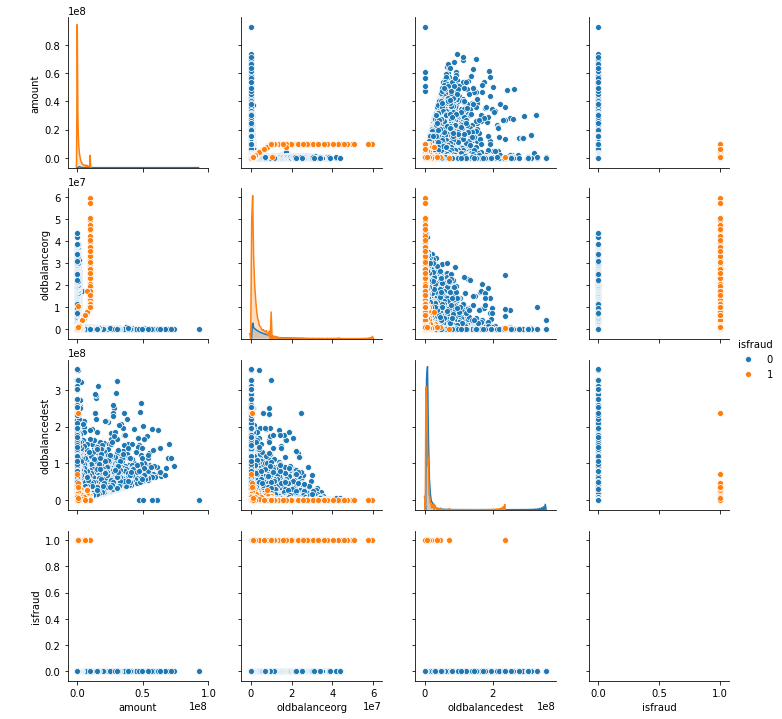

In [34]:
# lets pairplot the numerical data

plt.figure(figsize=(12,8))
sns.pairplot(fraud[['amount', 'oldbalanceorg', 'oldbalancedest', 'isfraud']], hue = 'isfraud')
plt.show()

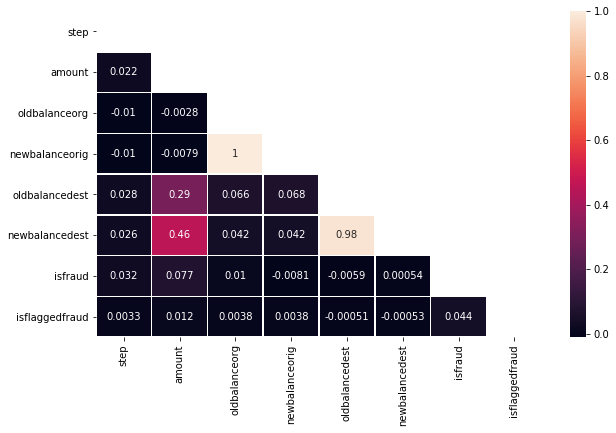

In [35]:
# lets see if theres any correlation between predictors
# newbalancingorig and oldbalanceorg has a corr of 1
# newbalancedest and oldbalancedest has a corr of 0.98
# new and oldbaalancedest has some corr with amount @ 0.46 and 0.29
fraud.corr()
fig = plt.figure(figsize = (10, 6))
mask = np.zeros_like(fraud.corr(), dtype = np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(fraud.corr(), annot = True, linewidths = 0.5, mask = mask)
plt.show()

# some feature engineering
Since fraudulent behavior aims to profit by trying to empty funds by first transferring to another account and then cashing out of the system, the remaining balance should be zero since everything is cashed out.<br>
<br>
If I were to fraud, I will not have a transaction that will create a surplus between the before and after the transaction, almost 100% of the time the transaction will leave the current account in deficit (almost 0)

In [36]:
is_fraud = fraud[fraud['isfraud'] == 1]
is_fraud.sample(20)

,step,type,amount,nameorig,oldbalanceorg,newbalanceorig,namedest,oldbalancedest,newbalancedest,isfraud,isflaggedfraud
4945978,351,transfer,118111.77,c454838857,118111.77,0.0,c838301055,0.00,0.00,1,0
4023009,299,transfer,1158358.08,c1857854292,1158358.08,0.0,c1179545940,0.00,0.00,1,0
1511389,152,cashout,102945.99,c1847949987,102945.99,0.0,c1663207814,2276404.45,2379350.44,1,0
6279176,643,cashout,3092085.39,c331136549,3092085.39,0.0,c447175296,120913.17,3212998.55,1,0
6145405,546,transfer,24773.86,c1068269457,24773.86,0.0,c746567344,0.00,0.00,1,0
5187820,362,transfer,7677120.59,c2068656014,7677120.59,0.0,c1266729216,0.00,0.00,1,0
1030352,58,cashout,109525.67,c924291724,109525.67,0.0,c1035427073,3997342.61,4106868.28,1,0
6168506,554,cashout,1025082.07,c152367037,1025082.07,0.0,c451693209,1430070.20,2455152.27,1,0
1870,1,cashout,25071.46,c1275464847,25071.46,0.0,c1364913072,9083.76,34155.22,1,0
3214345,249,cashout,10000000.00,c1919400809,10000000.00,0.0,c1527429194,0.00,10000000.00,1,0


In [37]:
# theres not much variance or much information we can get from the customer who started the fraudulent transactions
# this feature is not useful except tell us fraudulent activities are not done using a few set accounts
# theres not much info in 'namedest' as the variance is not significant enough to draw any insights
# almost all accounts for fraud observations are unique accounts
is_fraud.info()
print(len(is_fraud['nameorig'].unique()), len(is_fraud['namedest'].unique()))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8213 entries, 2 to 6362619
Data columns (total 11 columns):
step              8213 non-null int64
type              8213 non-null object
amount            8213 non-null float64
nameorig          8213 non-null object
oldbalanceorg     8213 non-null float64
newbalanceorig    8213 non-null float64
namedest          8213 non-null object
oldbalancedest    8213 non-null float64
newbalancedest    8213 non-null float64
isfraud           8213 non-null int64
isflaggedfraud    8213 non-null int64
dtypes: float64(5), int64(3), object(3)
memory usage: 770.0+ KB
8213 8169


In [38]:
# take a look at account balance behavior between fraud accounts
# almost half of them have a balance recipient of 0 even though the transfer amount is not 0
balance_f = is_fraud[(is_fraud['type'] == 'transfer') | \
                     (is_fraud['type'] == 'cashout') & \
                     (is_fraud['oldbalancedest'] == 0) & \
                     (is_fraud['newbalancedest'] == 0) & \
                     (is_fraud['amount'] != 0)]
balance_frac = len(balance_f) / len(is_fraud)
balance_frac

0.49908681358821383

In [39]:
# take a look at account balance behavior between non-fraud accounts
not_fraud = fraud[fraud['isfraud'] == 0]
balance_nf = not_fraud[(not_fraud['type'] == 'transfer') | \
                      (not_fraud['type'] == 'cashout') & \
                      (not_fraud['oldbalancedest'] == 0) & \
                      (not_fraud['newbalancedest'] == 0) & \
                      (not_fraud['amount'] != 0)]
balance_nfrac = len(balance_nf) / len(not_fraud)
balance_nfrac

0.08347151827070567

The data has several transactions with zero balances in the destination account both before and after a non-zero amount is transacted. <br>
The fraction of such transactions is much larger in fraudulent (49.91%) compared to genuine transactions (8.3%).
This can be an indication of fraudulent activity, can consider doing feature engineering on this aspect

In [40]:
# will drop some columns and eliminate some other rows that offers not significant insights
# elimination might help the sample imbalance, but may also drop some information
fraud_df = fraud.drop(['nameorig', 'namedest', 'isflaggedfraud'], axis = 1)
fraud_df = fraud_df[(fraud_df['type'] == 'cashout') | (fraud_df['type'] == 'transfer')]
print(len(fraud_df), len(fraud))
print('-' * 50)
fraud_df.info()

2770409 6362620
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2770409 entries, 2 to 6362619
Data columns (total 8 columns):
step              int64
type              object
amount            float64
oldbalanceorg     float64
newbalanceorig    float64
oldbalancedest    float64
newbalancedest    float64
isfraud           int64
dtypes: float64(5), int64(2), object(1)
memory usage: 190.2+ MB


In [41]:
fraud_df['type'] = [1 if x == 'cashout' else 0 for x in fraud_df['type']]
fraud_df['type'].value_counts()

1    2237500
0     532909
Name: type, dtype: int64

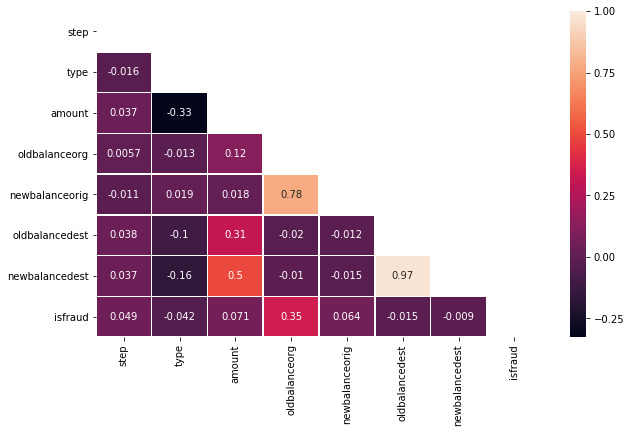

In [42]:
# lets check the correlation between the predictors
fraud_df.corr()
fig = plt.figure(figsize = (10, 6))
mask = np.zeros_like(fraud_df.corr(), dtype = np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(fraud_df.corr(), annot = True, linewidths = 0.5, mask = mask)
plt.show()

In [43]:
# some feature engineering for account balance
# imputing -1 will be quite useful for fraud detection algos
# kind of differentiating the fraud from the non fraud, transfer and cashout
fraud_df.loc[(fraud_df['oldbalancedest'] == 0) & \
             (fraud_df['newbalancedest'] == 0) & (fraud_df['amount'] != 0), ['oldbalancedest', 'newbalancedest']] = -1
fraud_df.loc[(fraud_df['oldbalanceorg'] == 0) & (fraud_df['newbalanceorig'] == 0) & (fraud_df['amount'] != 0), \
      ['oldbalanceorg', 'newbalanceorig']] = -1
fraud_df.sample(20)

,step,type,amount,oldbalanceorg,newbalanceorig,oldbalancedest,newbalancedest,isfraud
516509,20,1,59045.42,-1.00,-1.00,1039040.29,1098085.71,0
3757957,279,1,149371.20,-1.00,-1.00,3149196.79,3298568.00,0
361376,17,1,375124.59,9595.00,0.00,0.00,375124.59,0
4944851,351,1,208088.12,309162.00,101073.88,5547695.46,5755783.59,0
668077,36,1,214919.63,-1.00,-1.00,489889.72,704809.35,0
4256089,306,1,5181.54,104648.00,99466.46,0.00,5181.54,0
2912833,229,1,384943.68,378221.63,0.00,9057627.64,9442571.32,0
2388853,201,0,76499.77,-1.00,-1.00,7263046.52,7339546.30,0
3329162,253,1,73138.18,-1.00,-1.00,3135845.07,3208983.25,0
2420072,202,1,146597.19,10582.00,0.00,43057.95,189655.14,0


In [44]:
# now that we have done some initial feature engineering, lets tr to create some interactions between the features
# our higher level feature engineering have to account for the correlations.
# dest is from person to person, so 
fraud_df['finalbalanceorig'] = fraud_df['newbalanceorig'] - fraud_df['oldbalanceorg'] + fraud_df['amount']
fraud_df['finalbalancedest'] = fraud_df['oldbalancedest'] - fraud_df['newbalancedest'] + fraud_df['amount']
fraud_df.sample(20)

,step,type,amount,oldbalanceorg,newbalanceorig,oldbalancedest,newbalancedest,isfraud,finalbalanceorig,finalbalancedest
3204634,249,1,91040.44,-1.00,-1.0,5097300.11,5188340.55,0,91040.44,5.238689e-10
3005702,232,1,95951.54,-1.00,-1.0,318537.32,414488.86,0,95951.54,1.455192e-11
1877806,164,1,133735.48,287832.08,154096.6,3276952.54,3410688.03,0,0.00,-1.000000e-02
339249,16,1,236210.20,-1.00,-1.0,1634278.11,2037379.79,0,236210.20,-1.668915e+05
1607466,156,1,47787.88,-1.00,-1.0,69978.89,117766.77,0,47787.88,-7.275958e-12
3426212,256,1,313495.72,-1.00,-1.0,313771.46,627267.17,0,313495.72,1.000000e-02
1605436,156,1,371038.65,41708.00,0.0,0.00,371038.65,0,329330.65,0.000000e+00
793360,40,1,28062.71,9648.00,0.0,0.00,28062.71,0,18414.71,0.000000e+00
5555814,383,1,258795.67,-1.00,-1.0,12620159.02,12878954.69,0,258795.67,8.731149e-11
4059111,300,1,28584.55,10873.00,0.0,215515.46,244100.01,0,17711.55,-1.818989e-11


In [45]:
# whats the difference between the activities of fraudulent and genuine transactions
# Theres 8213 counts of fraud, compared to 2770409 observations, severely imbalanced class
X = fraud_df.drop('isfraud', axis = 1).reset_index()
y = fraud_df[['isfraud']].reset_index()
X = X.drop('index', axis = 1)
y = y.drop('index', axis = 1)
y = y['isfraud']
print(len(X), len(y))
y.value_counts()

2770409 2770409


0    2762196
1       8213
Name: isfraud, dtype: int64

In [46]:
# lets do this visualisation function i learnt from kaggle kernel
def plotStrip(x, y, hue, figsize = (12, 8)):
    
    fig = plt.figure(figsize = figsize)
    colours = plt.cm.tab10(np.linspace(0, 1, 9))
    with sns.axes_style('ticks'):
        ax = sns.stripplot(x, y, hue = hue, jitter = 0.4, marker = '.', size = 4, palette = colours)
        ax.set_xlabel('')
        ax.set_xticklabels(['genuine', 'fraudulent'], size = 16)
        for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(2)

        handles, labels = ax.get_legend_handles_labels()
        plt.legend(handles, ['Transfer', 'Cash out'], bbox_to_anchor=(1, 1), \
               loc=2, borderaxespad=0, fontsize = 16);
    return ax

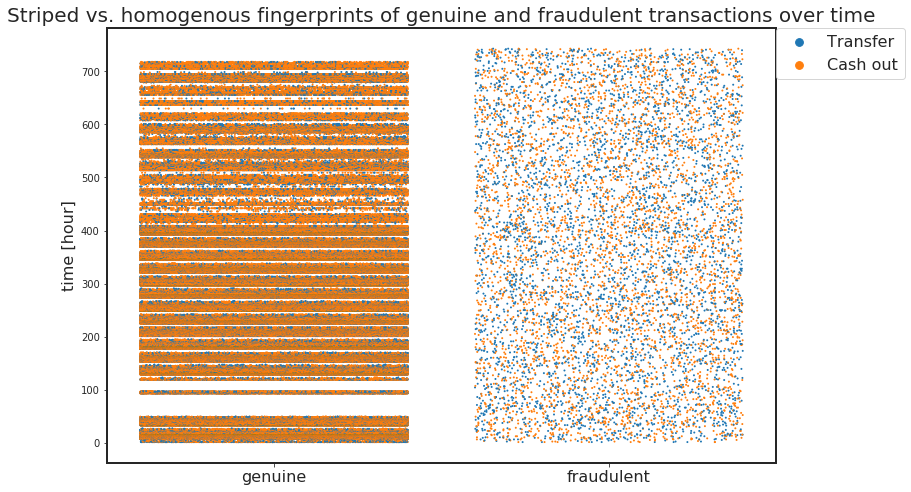

In [22]:
ax = plotStrip(y[:len(X)], X.step[:len(X)], X.type[:len(X)])
ax.set_ylabel('time [hour]', size = 16)
ax.set_title('Striped vs. homogenous fingerprints of genuine and fraudulent transactions over time', size = 20);

The plot below shows how the fraudulent and genuine transactions yield different fingerprints when their dispersion is viewed over time. It is clear that fradulent transactions are more homogenously distributed over time compared to genuine transactions (ordered, with some sort of pattern). Also apparent is that CASH-OUTs outnumber TRANSFERs in genuine transactions (more orange than blue), in contrast to a balanced distribution between them in fraudulent transactions with no dicernable pattern. Note that the the width of each 'fingerprint' is set by the 'jitter' parameter in the plotStrip function above which attempts to separate out and plot transactions occuring at the same time with different abscissae (distance away from the y-axis parallel to the x-axis)

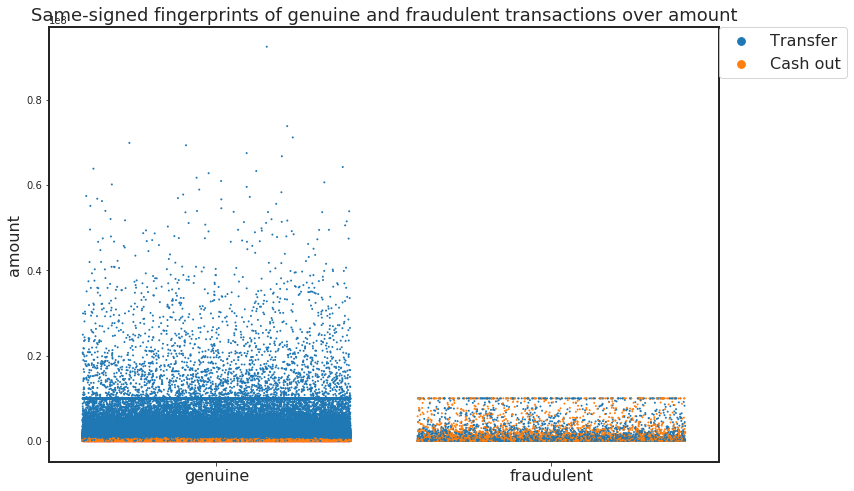

In [23]:
ax = plotStrip(y[:len(X)], X.amount[:len(X)], X.type[:len(X)], figsize = (12, 8))
ax.set_ylabel('amount', size = 16)
ax.set_title('Same-signed fingerprints of genuine and fraudulent transactions over amount', size = 18);

The two plots above show that although the presence of fraud in a transaction can be discerned by the original amount feature, the new finalbalancedest and finalbalanceorig features are more effective at making a distinction by including their interaction between the before and after. We are using not just individual features but the same features with some form of feature engineering. <br>
<br>
To further prove the effectiveness of the feature engineered columns we use the same plot with the engineered feature.

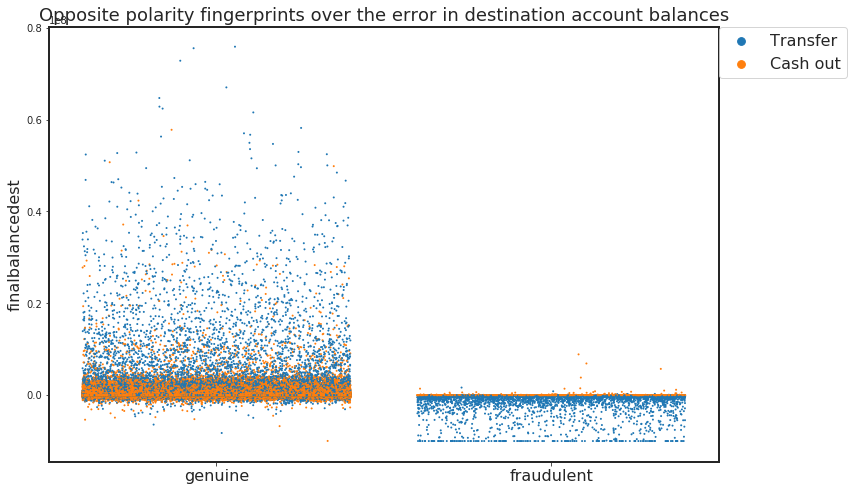

In [24]:
ax = plotStrip(y[:len(X)], - X.finalbalancedest[:len(X)], X.type[:len(X)], figsize = (12, 8))
ax.set_ylabel('finalbalancedest', size = 16)
ax.set_title('Opposite polarity fingerprints over the final destination account balances', size = 18);

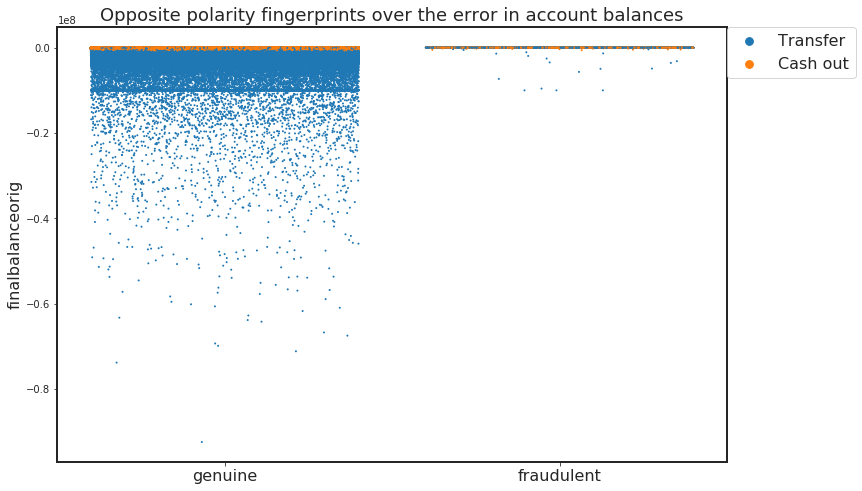

In [25]:
ax = plotStrip(y[:len(X)], - X.finalbalanceorig[:len(X)], X.type[:len(X)], figsize = (12, 8))
ax.set_ylabel('finalbalanceorig', size = 16)
ax.set_title('Opposite polarity fingerprints over the error in account balances', size = 18);

From the plot above, seems like the finalbalanceorig where the final balance of the original account does not give us much info.

In [47]:
y_scatter = fraud_df[['isfraud']].reset_index()
y_scatter = y_scatter.drop('index', axis = 1)
y_scatter.head()

,isfraud
0,1
1,1
2,0
3,0
4,0


In [48]:
y_scatter['isfraud'].value_counts()
X_scatter = X
x_axis = 'finalbalancedest'
y_axis = 'step'
z_axis = 'finalbalanceorig'
print(len(X_scatter[y_scatter['isfraud'] == 0]['finalbalancedest']), len(X_scatter[y_scatter['isfraud'] == 0]['step']))
print(len(X_scatter[y_scatter['isfraud'] == 1]['finalbalancedest']), len(X_scatter[y_scatter['isfraud'] == 1]['step']))
print(len(X_scatter[y_scatter['isfraud'] == 0]['finalbalanceorig']))

2762196 2762196
8213 8213
2762196


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\__init__.py:855: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)


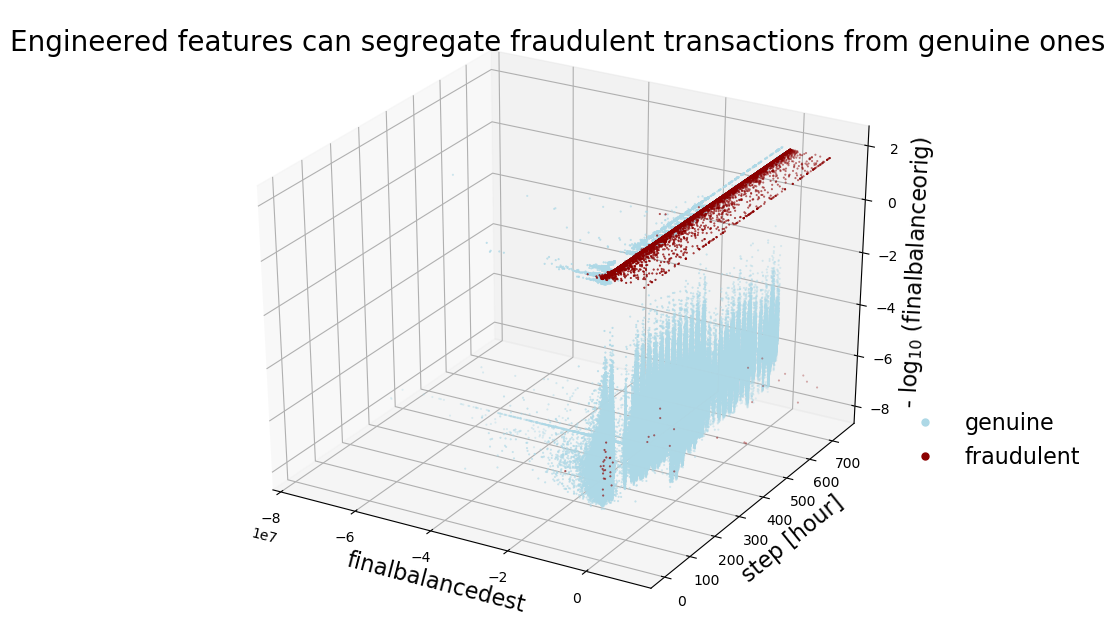

In [108]:
x_axis = 'finalbalancedest'
y_axis = 'step'
z_axis = 'finalbalanceorig'
zOffset = 0.02

sns.reset_orig() # prevent seaborn from over-riding mplot3d defaults

fig = plt.figure(figsize = (10, 8))
ax = fig.add_subplot(111, projection = '3d')

ax.scatter(X_scatter[y_scatter['isfraud'] == 0]['finalbalancedest'], X_scatter[y_scatter['isfraud'] == 0]['step'], \
           -np.log10(X_scatter[y_scatter['isfraud'] == 0]['finalbalanceorig'] + zOffset), c = 'lightblue', marker = '.', \
           s = 1, label = 'genuine')
    
ax.scatter(X_scatter[y_scatter['isfraud'] == 1]['finalbalancedest'], X_scatter[y_scatter['isfraud'] == 1]['step'], \
           -np.log10(X_scatter[y_scatter['isfraud'] == 1]['finalbalanceorig'] + zOffset), c = 'darkred', marker = '.', \
           s = 1, label = 'fraudulent')

ax.set_xlabel(x_axis, size = 16); 
ax.set_ylabel(y_axis + ' [hour]', size = 16); 
ax.set_zlabel('- log$_{10}$ (' + z_axis + ')', size = 16)
ax.set_title('Engineered features can segregate fraudulent transactions from genuine ones', size = 20)

plt.axis('tight')
ax.grid(1)

fraud = mlines.Line2D([], [], linewidth = 0, color = 'darkred', marker='.', markersize = 10, label='fraudulent')
not_fraud = mlines.Line2D([], [], linewidth = 0, color='lightblue', marker='.', markersize = 10, label='genuine')

plt.legend(handles = [not_fraud, fraud], 
           bbox_to_anchor = (1.20, 0.38 ), frameon = False, prop={'size': 16});

Now we have the features engineering done up, EDA mostly done we go on to resample the dataset to ensure the trained model is not biased. <br>
<br>
Either up or down-sample. Lets try downsampling first, using NearMiss from imblearn and some other resampling techniques. <br>
<br>
For modelling lets try some basic classification to start

In [49]:
# before modelling lets check out the skewness of the entire dataset, get a feel of the class imbalance we are working with
skew = len(fraud[fraud['isfraud'] == 1]) / len(fraud)
skew

0.001290820448180152

Since the data is highly skewed, lets use the area under the precision-recall curve (AUPRC) rather than the conventional area under the receiver operating characteristic (AUROC). The he AUPRC is more sensitive to differences between algorithms and their parameter settings rather than the AUROC (Davis and Goadrich et.al) - http://pages.cs.wisc.edu/~jdavis/davisgoadrichcamera2.pdf

In [27]:
# one thing about downsampling is that the training set will be alot smaller than the test set, not sure whats the reprecussion of this senario

X = X.astype(float)
ss = StandardScaler()
X_ss = ss.fit_transform(X)
stratk = StratifiedKFold(n_splits = 5)

for train_index, test_index in stratk.split(X_ss, y):
    X_train, X_test = X_ss[train_index, :], X_ss[test_index, :]
    y_train, y_test = y[train_index], y[test_index]
    nm = NearMiss(random_state = 42)
    X_train_near, y_train_near = nm.fit_sample(X_train, y_train)
    y_train_near = pd.Series(y_train_near)
    print(len(X_train), len(X_test), len(y_train), len(y_test))
    print(len(X_train_near), len(y_train_near))

2216326 554083 2216326 554083
13140 13140
2216327 554082 2216327 554082
13140 13140
2216327 554082 2216327 554082
13140 13140
2216328 554081 2216328 554081
13142 13142
2216328 554081 2216328 554081
13142 13142


In [50]:
#Lets try using original dataset and a ML algorithm based on ensembles of decision trees that intrinsically performs well on imbalanced data.
# random_state 42 becuz its the answer to everything in the universe
# Ensure there are both 1s and 0s in train and test set.

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
print(len(X_train),  len(y_train), len(X_test), len(y_test))
print(pd.Series(y_train).value_counts(), '\n', pd.Series(y_test).value_counts())

2216327 2216327 554082 554082
0    2209760
1       6567
Name: isfraud, dtype: int64 
 0    552436
1      1646
Name: isfraud, dtype: int64


In [51]:
# XGBoost classifier to start, because its a model that doesnt really require any sampling technique, but have to account for class imbalance
# overfitting?? 0.99 sounds too good to be true

weights = ((y == 0).sum()) / (1.0 * (y == 1).sum())
xgb = XGBClassifier(max_depth = 3, learning_rate = 0.1, scale_pos_weight = weights, n_jobs = -1)
train_score = cross_val_score(xgb, X_train, y_train, cv = 10, scoring = 'average_precision')
model_xgb = xgb.fit(X_train, y_train)
proba = model_xgb.predict_proba(X_test)
y_hat_xgb = model_xgb.predict(X_test)
bal_score = balanced_accuracy_score(y_test, y_hat_xgb)
matrix = pd.DataFrame(confusion_matrix(y_test, y_hat_xgb), columns = ['pred_0', 'pred_1'], index = ['0', '1'])
print('AUPRC on train: ', train_score, np.mean(train_score), np.std(train_score))
print('AUPRC on test: ', average_precision_score(y_test, proba[:, 1]))
print('Balanced Accuracy Score: ', bal_score)  
print(classification_report(y_test, y_hat_xgb))
print(matrix)

AUPRC on train:  [0.99848247 0.99848628 0.99892476 0.99792684 0.99685617 0.9966827
 0.99770039 0.99707526 0.99706412 0.99987226] 0.9979071243981679 0.0009804736823249872
AUPRC on test:  0.9968752860973232
Balanced Accuracy Score:  0.9977324402238614
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    552436
           1       0.91      1.00      0.95      1646

   micro avg       1.00      1.00      1.00    554082
   macro avg       0.96      1.00      0.98    554082
weighted avg       1.00      1.00      1.00    554082

   pred_0  pred_1
0  552280     156
1       7    1639


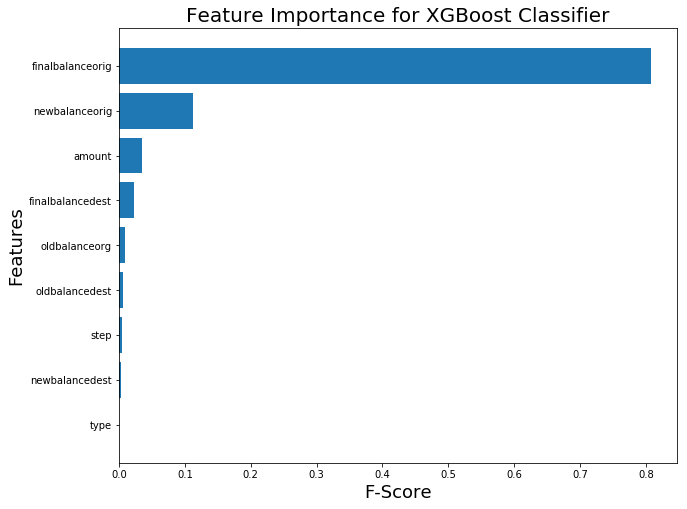

In [117]:
# Some model analysis, feature importance using weights
# The number of times a feature is used to split the data across all trees

features = list(X.columns)
f_impt = model_xgb.feature_importances_
feature_impt = pd.DataFrame()
feature_impt['feature'] = features
feature_impt['importance'] = f_impt
feature_impt = feature_impt.sort_values(by = 'importance', ascending = True).reset_index().drop('index', axis = 1)
fig = plt.figure(figsize = (10, 8))
ax = plt.gca()
ax.barh(feature_impt['feature'], feature_impt['importance'])
ax.set_xlabel('F-Score', size = 18) 
ax.set_ylabel('Features', size = 18)
ax.set_title('Feature Importance for XGBoost Classifier', size = 20)
plt.show()

In [52]:
# train and test data will be same as xgboost for comparison
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
print(len(X_train),  len(y_train), len(X_test), len(y_test))
print(pd.Series(y_train).value_counts(), '\n', pd.Series(y_test).value_counts())

2216327 2216327 554082 554082
0    2209760
1       6567
Name: isfraud, dtype: int64 
 0    552436
1      1646
Name: isfraud, dtype: int64


In [53]:
# let try catboost for fun

weights = ((y == 0).sum()) / (1.0 * (y == 1).sum())
catboost = CatBoostClassifier(n_estimators = 100, learning_rate = 0.1, depth = 3, scale_pos_weight = weights, verbose = False)
train_score = cross_val_score(catboost, X_train, y_train, cv = 10, scoring = 'average_precision')
model_cat = catboost.fit(X_train, y_train)
proba = model_cat.predict_proba(X_test)
y_hat_cat = model_cat.predict(X_test)
bal_score = balanced_accuracy_score(y_test, y_hat_cat)
matrix = pd.DataFrame(confusion_matrix(y_test, y_hat_cat), columns = ['pred_0', 'pred_1'], index = ['0', '1'])
print('AUPRC on train: ', train_score, np.mean(train_score), np.std(train_score))
print('AUPRC on test: ', average_precision_score(y_test, proba[:, 1]))
print('Balanced Accuracy Score: ', bal_score)  
print(classification_report(y_test, y_hat_cat))
print(matrix)

AUPRC on train:  [0.99848257 0.99795855 0.9996066  0.99834539 0.9968112  0.99669493
 0.99702902 0.99702559 0.99688956 0.9998645 ] 0.997870790360585 0.0011174192184374842
AUPRC on test:  0.9971794800576785
Balanced Accuracy Score:  0.9977242944839024
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    552436
           1       0.91      1.00      0.95      1646

   micro avg       1.00      1.00      1.00    554082
   macro avg       0.95      1.00      0.97    554082
weighted avg       1.00      1.00      1.00    554082

   pred_0  pred_1
0  552271     165
1       7    1639


            feature  importance
0              type    0.240243
1    newbalancedest    0.363974
2    oldbalancedest    1.067341
3     oldbalanceorg    1.752207
4              step    2.672229
5            amount    2.756956
6  finalbalancedest    2.912313
7    newbalanceorig   14.930891
8  finalbalanceorig   73.303845


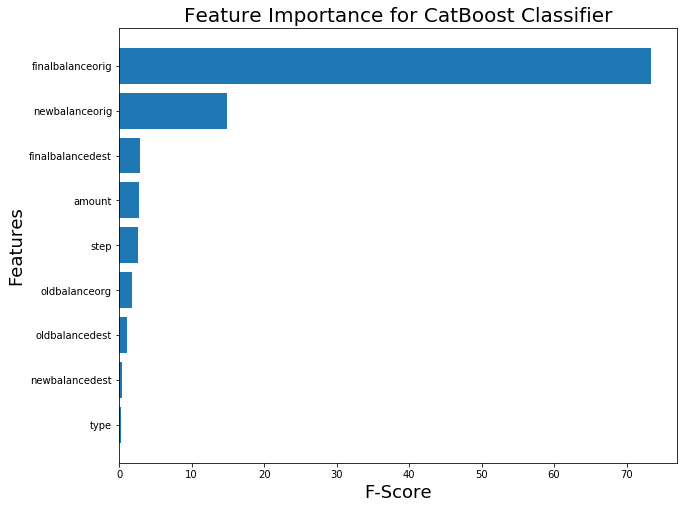

In [116]:
# lets take a look at the feature importance for catboost
# Feature importance using weights
# The number of times a feature is used to split the data across all trees

features = list(X.columns)
f_impt = model_cat.feature_importances_
feature_impt = pd.DataFrame()
feature_impt['feature'] = features
feature_impt['importance'] = f_impt
feature_impt = feature_impt.sort_values(by = 'importance', ascending = True).reset_index().drop('index', axis = 1)
print(feature_impt)
fig = plt.figure(figsize = (10, 8))
ax = plt.gca()
ax.barh(feature_impt['feature'], feature_impt['importance'])
ax.set_xlabel('F-Score', size = 18) 
ax.set_ylabel('Features', size = 18)
ax.set_title('Feature Importance for CatBoost Classifier', size = 20)
plt.show()

In [21]:
def sampling_func(X_train_under, X_te, y_train_under, y_te):
    logreg = LogisticRegression(C = 0.1, random_state = 42, penalty = 'l2', solver = 'liblinear', class_weight = 'balanced')
    train_score_logreg = cross_val_score(logreg, X_train_under, y_train_under, cv = 5, scoring = 'average_precision')
    model_logreg = logreg.fit(X_train_under, y_train_under)
    y_hat_logreg = model_logreg.predict(X_te)
    recall_logreg = recall_score(y_te, y_hat_logreg)
    score_logreg = balanced_accuracy_score(y_te, y_hat_logreg)
    auprc_logreg = average_precision_score(y_te, y_hat_logreg)
    matrix_logreg = pd.DataFrame(confusion_matrix(y_te, y_hat_logreg), columns = ['pred_0', 'pred_1'], index = ['0', '1'])

    dt = DecisionTreeClassifier()
    train_score_dt = cross_val_score(dt, X_train_under, y_train_under, cv = 5)
    model_dt = dt.fit(X_train_under, y_train_under)
    y_hat_dt = model_dt.predict(X_te)
    score_dt = balanced_accuracy_score(y_te, y_hat_dt)
    auprc_dt = average_precision_score(y_te, y_hat_dt)
    recall_dt = recall_score(y_te, y_hat_dt)
    matrix_dt = pd.DataFrame(confusion_matrix(y_te, y_hat_dt), columns = ['pred_0', 'pred_1'], index = ['0', '1'])

    rf = RandomForestClassifier(n_estimators = 500)
    train_score_rf = cross_val_score(rf, X_train_under, y_train_under, cv = 5, scoring = 'average_precision')
    model_rf = rf.fit(X_train_under, y_train_under)
    y_hat_rf = model_rf.predict(X_te)
    score_rf = balanced_accuracy_score(y_te, y_hat_rf)
    auprc_rf = average_precision_score(y_te, y_hat_rf)
    recall_rf = recall_score(y_te, y_hat_rf)
    matrix_rf = pd.DataFrame(confusion_matrix(y_te, y_hat_rf), columns = ['pred_0', 'pred_1'], index = ['0', '1'])

    print(classification_report(y_te, y_hat_logreg))
    print('Logistic Regression - AUPRC (train): ', train_score_logreg, '\n', np.mean(train_score_logreg), np.std(train_score_logreg))
    print('Logistic Regression - AUPRC (test): ', auprc_logreg)
    print('Logistic Regression - Recall: ', recall_logreg)
    print('Logistic Regression - Balanced_acc_score: ', score_logreg)
    print('Logistic Regression - Confusion Matrix: ', matrix_logreg)
    print('-' * 50)
    print(classification_report(y_te, y_hat_dt))
    print('Decision Tree - AUPRC (train): ', train_score_dt, '\n', np.mean(train_score_dt), np.std(train_score_dt))
    print('Decision Tree - AUPRC (test): ', auprc_dt)
    print('Decision Tree - Recall: ', recall_dt)
    print('Decision Tree - Balanced_acc_score: ', score_dt)
    print('Decision Tree - Confusion Matrix: ', matrix_dt)
    print('-' * 50)
    print(classification_report(y_te, y_hat_rf))
    print('Random Forest - AUPRC (train): ', train_score_rf, '\n', np.mean(train_score_rf), np.std(train_score_rf))
    print('Random Forest - AUPRC (test): ', auprc_rf)
    print('Random Forest - Recall: ', recall_rf)
    print('Random Forest - Balanced_acc_score: ', score_rf)
    print('Random Forest - Confusion Matrix: ', matrix_rf)

In [22]:
X = X.astype(float)
ss = StandardScaler()
X = ss.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
print(len(X_train), len(X_test), len(y_train), len(y_test))

2216327 554082 2216327 554082


In [34]:
# logistic regression, decision tree, random forest
# train test split(undersampling, NearMiss3) with standardization, 80-20 split
# 

nm = NearMiss(random_state = 42, version = 3)
X_train_nm, y_train_nm = nm.fit_sample(X_train, y_train)
sampling_func(X_train_nm, X_test, y_train_nm, y_test)

C:\ProgramData\Anaconda3\lib\site-packages\imblearn\under_sampling\_prototype_selection\_nearmiss.py:194: UserWarning: The number of the samples to be selected is larger than the number of samples available. The balancing ratio cannot be ensure and all samples will be returned.
  warnings.warn('The number of the samples to be selected is larger'


              precision    recall  f1-score   support

           0       1.00      1.00      1.00    552436
           1       0.30      0.65      0.41      1646

   micro avg       0.99      0.99      0.99    554082
   macro avg       0.65      0.83      0.71    554082
weighted avg       1.00      0.99      1.00    554082

Logistic Regression - AUPRC (train):  [0.6983278  0.88214981 0.8943329  0.91376436 0.93637012] 
 0.864989001048037 0.08532973067225413
Logistic Regression - AUPRC (test):  0.19956416859468992
Logistic Regression - Recall:  0.6549210206561361
Logistic Regression - Balanced_acc_score:  0.8252177165926851
--------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.84      0.91    552436
           1       0.02      1.00      0.03      1646

   micro avg       0.84      0.84      0.84    554082
   macro avg       0.51      0.92      0.47    554082
weighted avg       1.00      0.84      0.91   

In [ ]:
# train test split(undersampling, CondensedNearestNeighbour), 80-20 split
# 

cnn = CondensedNearestNeighbour(random_state = 42)
X_train_cnn, y_train_cnn = cnn.fit_sample(X_train, y_train)
sampling_func(X_train_cnn, X_test, y_train_cnn, y_test)

In [ ]:
# train test split(undersampling, ClusterCentroids), 80-20 split
# 

cc = ClusterCentroids(random_state = 42)
X_train_cc, y_train_cc = cc.fit_sample(X_train, y_train)
sampling_func(X_train_cc, X_test, y_train_cc, y_test)

In [ ]:
# train test split(oversampling, SMOTE), 80-20 split
#

sm = SMOTE(random_state = 42)
X_train_sm, y_train_sm = sm.fit_sample(X_train, y_train)
sampling_func(X_train_sm, X_test, y_train_sm, y_test)

In [ ]:
# train test split(oversampling, ADASYN), 80-20 split
#

adasyn = ADASYN(random_state = 42)
X_train_ada, y_train_ada = adasyn.fit_sample(X_train, y_train)
sampling_func(X_train_ada, X_test, y_train_ada, y_test)

In [ ]:
# train test split(oversampling, RandomOverSampler), 80-20 split
#

ros = RandomOverSampler(random_state = 42)
X_train_ros, y_train_ros = ros.fit_sample(X_train, y_train)
sampling_func(X_train_ros, X_test, y_train_ros, y_test)

Good afternoon everyone, today I will be presenting on my capstone project. Detecting fraudulent transactions. 
Before we jump right into it, What exactly is fraud?
Fraud, from how i see it, its an art (mona lisa), it is an art of stealing money.
Therefore like all art, there is a process. Just that this process usually involves someone doing something brillant to cheat the system and profit and that socially unacceptable. But it is still an art non-the-less!
Now that I have establish that fraud is an art with some form of process, like all processes, it will have a pattern. And the pattern ladies and gentlemen, is the whole point of fraud detection. 

The dataset I choose to apply my brillance to is a synthetic dataset that simulates mobile money transactions based on real transactions extracted from a mobile money service implemented in an African country. The mobile service is provided by a MNC that runs in more than 14 other countries.

The features avaliable to work with are the above, most notably 
type of transaction, <br>
amount of the transaction in local currency, <br>
who started the transaction and who is the recipient of the transaction, <br>
balance before and after the transaction, <br>
balance of the recipient before and after the transaction, <br>
the target variable of whether the transaction is fradulent, <br>
and which transactions are flagged as fraudulent, <br>
a total of 12 features and approximately 6.4 million rows, <br> 
<br>
and heres the catch, theres only 8213 fraud cases within the 6.4 million making my dataset a severely imbalanced dataset and my life more difficult. To put things in persepctive, we are trying to find 10 person in china that can literally be anywhere. <br> 
<br> 
Finding a needle, in a haystack

Besides alot of coffee and mental blocks. My EDA process took up a huge part of the project. It involves the normal eda stuff like .corr(), looking at which features are useful as a predictor, visualising, scrutinising each feature to determine if it should be a predictor and of course feature engineering to let machine learning model better make sense of the dataset. <br>
<br> 
Some visualisations are from the eda process which were critical to the modelling process, <br>
<br>
(first boxplot): From this boxplot, we can conclude that fraud only occurs in 2 types of transactions, CASH-IN & TRANSFER.
(second graph): This shows the relationship between transactions and time. From this graph, fradulent transactions are more homogenously distributed over time compared to genuine transactions (ordered, with some sort of pattern). Also apparent is that CASH-OUTs outnumber TRANSFERs in genuine transactions (more orange than blue), in contrast to a balanced distribution between them in fraudulent transactions with no dicernable pattern. Does this pattern that happens in genuine transactions help me detect fraud ones? The answer is, IT DEPENDS and therefore while it gives us some info which may or may not be useful, we can only conclude that fraud has nothing to do with time, it happens at every point of time.

How did i do my feature engineering?